### This notebook is to answer the RQ4: How does technical lag propagate over transitive runtime dependencies?

In [37]:
%matplotlib inline
import seaborn as sns; #sns.set(style="ticks", color_codes=True)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import scipy
style.use('fast')
from datetime import datetime
import re
import os

sns.set_style('ticks',{'legend.frameon':True} )
sns.set_palette('colorblind')
FIG_SIZE = (12, 3)
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['text.usetex'] = True

plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['axes.labelsize']= 22

PALETTE_BASE = sns.color_palette('muted', n_colors=12)
blue=PALETTE_BASE[0]
green=PALETTE_BASE[1] 
red=PALETTE_BASE[2] 
purple=PALETTE_BASE[3]
version_colors=['orange',red, 'gray']

# LOAD DATA

In [111]:
import networkx as nx

def hierarchy_pos(G, root, width=1., vert_gap = 0.4, vert_loc = 0, xcenter = 0.5, 
                  pos = None, parent = None):
    '''If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node of current branch
       width: horizontal space allocated for this branch - avoids overlap with other branches
       vert_gap: gap between levels of hierarchy
       vert_loc: vertical location of root
       xcenter: horizontal location of root
       pos: a dict saying where all nodes go if they have been assigned
       parent: parent of this branch.'''
    if pos == None:
        pos = {root:(xcenter,vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
    neighbors = list(G.neighbors(root))
    if parent != None:   #this should be removed for directed graphs.
        neighbors.remove(parent)  #if directed, then parent not in neighbors.
    if len(neighbors)!=0:
        dx = width/len(neighbors) 
        nextx = xcenter - width/2 - dx/2
        for neighbor in neighbors:
            nextx += dx
            pos = hierarchy_pos(G,neighbor, width = dx, vert_gap = vert_gap, 
                                vert_loc = vert_loc-vert_gap, xcenter=nextx, pos=pos, 
                                parent = root)
    return pos

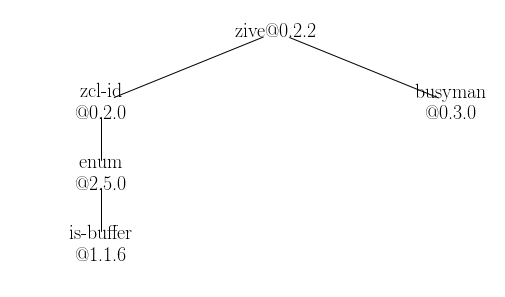

In [114]:
import matplotlib.pyplot as plt
import networkx as nx
G=nx.Graph()
G.add_edges_from([
('zive@0.2.2', 'busyman\n@0.3.0'),
('zive@0.2.2', 'zcl-id\n@0.2.0'),
('zcl-id\n@0.2.0', 'enum\n@2.5.0'),
('enum\n@2.5.0', 'is-buffer\n@1.1.6'),

])
pos = hierarchy_pos(G,'zive@0.2.2')    
nx.draw(G, pos=pos, with_labels=True, node_color="white", node_size=700 ,font_size=20)
fig = plt.gcf()
fig.set_size_inches(6,3.5)

#fig.savefig('/home/neglectos/Desktop/repositories/jsep18technicallag/figures/transitive_zive.eps', bbox_inches='tight', facecolor='white')

# LOAD THE TRANSITIVE TECHNICAL LAG EVOLUTION
Note that because of memory errors, this dataframe is filtred from packages with zero techlag or without any dependencies.

It is also filtred from the spam packages and pre releases.

The origine dataframe size is: 163,867,660 rows

In [2]:
df_all=pd.read_csv('../../../jsep2018/csv/transitive/transitive_lag_filtred.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)
len(df_all)

62889161

In [101]:
print('Which means that {} of all dependencies are outdated.'.format(62889161*100/163867660))

Which means that 38.3780185791388 of all dependencies are outdated.


In [3]:
first_date="2010-12-01"
last_date="2018-04-30"
date_period = pd.to_datetime(first_date), pd.to_datetime(last_date)

In [4]:
for x in ['Patch','Minor','Major','time_lag','level']:
    df_all[x]=df_all[x].apply(float)

Now, skip this code until the analysis of version lag

In [3]:
#df_all=pd.concat(df_all)
#df_all=df_all.sort_values('level')
#df_all=df_all.groupby(['package','dependency','date']).first().reset_index()

In [4]:
#df_all['date']=df_all['date'].apply(lambda x : x.split('-')[0]+'-04-30' if '04-31' in str(x)
#                                    else str(x))
#df_all['level']=df_all['level'].apply(lambda x: int(x)+1)

In [5]:
df_all.rename(columns={'package_root':'package'}, inplace=True)

In [10]:
df_all.package.drop_duplicates().size

545676

In [7]:
df_all['package2']=df_all['package'].apply(lambda x: '@'.join(x.split('@')[:-1]))
df_all['dependency2']=df_all['dependency'].apply(lambda x: '@'.join(x.split('@')[:-1]))

In [8]:
df_all[['package','dependency2']].drop_duplicates().size

14368250

In [9]:
df_all.package2.drop_duplicates().size

65535

In [10]:
df_all.dependency2.drop_duplicates().size

46949

In [11]:
df_all[['package','date']].drop_duplicates().size

991088

In [12]:
df_all.package.drop_duplicates().size

158197

In [13]:
df_all.dependency.drop_duplicates().size

125875

In [14]:
df_all.dependency.size

24904066

In [15]:
df_all.package.size

24904066

In [16]:
df_all.dependency.drop_duplicates().size

125875

# Only outdated

In [6]:
df_all=df_all.query('time_lag!=0')
df_all['date']=df_all['date'].apply(lambda x: '2018-03-30' if x=="2018-04-30"
                                   else x)
len(df_all)

62889161

In [15]:
# df_all.to_csv('/home/neglectos/Desktop/lab/jsep2018/csv/transitive/transitive_lag_filtred.csv', index=False, sep=';')

# Version lag

In [40]:
(df_all.head().drop(['time_lag','level','dependency'],axis=1)
            .groupby(['package','date'])
    .first().sum())

Major     0.0
Minor     1.0
Patch    16.0
dtype: float64

In [36]:
(df_all.head().drop(['time_lag','level','dependency'],axis=1)
            .groupby(['package','date'])
            .sum()
)

,,Major,Minor,Patch
package,date,,,
FastLegS@0.0.7,2011-04-30,0.0,0.0,2.0
drawback@0.1.2,2011-04-30,0.0,1.0,6.0
jeesh@0.0.1,2011-04-30,0.0,0.0,4.0
kanso@0.0.3,2011-04-30,0.0,0.0,2.0
yui-repl@0.0.8,2011-04-30,0.0,0.0,2.0


In [7]:
df_all_sum=(df_all.head(62889161)
            .drop(['time_lag','level','dependency'],axis=1)
            .groupby(['package','date'])
            .sum()
           )

In [8]:
df_all_sum.reset_index(inplace=True)

In [9]:
df_all_sum['date']=df_all_sum['date'].apply(lambda x : str(x).split('-')[0]+'-'+str(x).split('-')[1])
df_all_sum_melted=df_all_sum.melt(id_vars=['package','date'])

In [10]:
df_all_sum.head()

,package,date,Major,Minor,Patch
0,0-0@1.0.2,2016-12,87.0,86.0,252.0
1,0-0@1.0.2,2017-04,93.0,94.0,278.0
2,0-0@1.0.2,2017-08,114.0,109.0,318.0
3,0-0@1.0.2,2017-12,118.0,112.0,311.0
4,0-0@1.0.2,2018-03,79.0,16.0,66.0


In [53]:
len(df_all_sum.query('date<"2015"'))

53893

In [11]:
print(df_all_sum.Major.median(),
      df_all_sum.Minor.median(),
      df_all_sum.Patch.median()
     )

10.0 20.0 40.0


In [12]:
df_all_sum['date']=pd.to_datetime(df_all_sum['date'])

Patch
Minor
Major


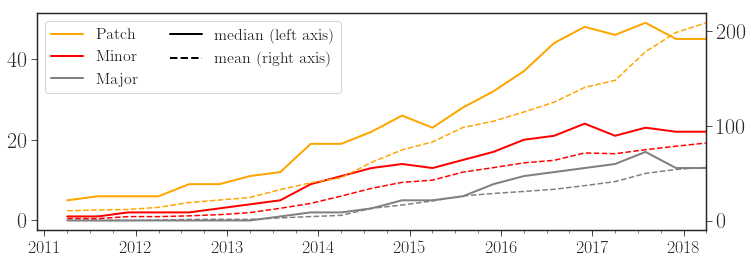

In [91]:

size=[20,30,100]
dfs={}
for x in ['Patch','Minor','Major']:
    dfs[x]=(df_all_sum.
            groupby(pd.Grouper(key='date', freq='4M'))[x].
            describe()[['mean', '25%', '50%', '75%']] 
           )

colors={}
colors['Patch']='orange'
colors['Minor']='r'
colors['Major']='gray'

#fig, axes = plt.subplots(3, 1, sharex=True, sharey=False)
#fig.set_size_inches(9,8)
for i, x in enumerate(['Major','Minor','Patch']):
    #fig, ax = plt.subplots()
    df_tmp=dfs[x]
    ax=df_tmp['50%'].rename('median').plot( color=colors[x], linewidth=2)
    #ax2=df_tmp['mean'].plot(style='--', color=colors[x])
    #ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], color=colors[x], alpha=0.2)
    ax.legend('')
    
ax.set(
    xlabel='',
    #ylabel='Median version lag',
    xlim=date_period,
    #ylim=(0,150)
)

ax2 = ax.twinx()

for i, x in enumerate(['Major','Minor','Patch']):
    #fig, ax = plt.subplots()
    df_tmp=dfs[x]
    #ax=df_tmp['50%'].rename('median').plot( color=colors[x], linewidth=2)
    ax2=df_tmp['mean'].plot(style='--', ax=ax2, color=colors[x])
    #ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], color=colors[x], alpha=0.2)
    ax.legend('')
ax2.set(
    xlabel='',
    #ylabel='Mean version lag',
    xlim=date_period,
    #ylim=(0,150)
)


ax.figure.set_size_inches(12,4)

from matplotlib.lines import Line2D
lines = []
labels = []
for key in ['Patch','Minor','Major']:
    #lines.append(Line2D([0], [0], color=colors[key], linewidth=3, linestyle='--'))
    #labels.append(key+" mean")
    print(key)
    lines.append(Line2D([0], [0], color=colors[key], linewidth=2))
    labels.append(key)
lines.append(Line2D([0], [0], color='black', linewidth=2))
labels.append('median (left axis)')
lines.append(Line2D([0], [0], color='black', linewidth=2, linestyle='--'))
labels.append('mean (right axis)')
ax.legend(lines, labels, ncol=2, loc='upper left',  prop={'size': 16, 'weight':'bold'})
#ax.set(yscale="log")
ax.figure.savefig('/home/neglectos/Desktop/repositories/jsep18technicallag/figures/transitive_vl.pdf', bbox_inches='tight', facecolor='white')

# Time lag

In [33]:
df_all_time=(df_all.head(62889161)
  .drop(['Major','Minor','Patch','level','dependency'],axis=1)
 .groupby(['package','date'])
 .agg('max')
 .reset_index()
)
df_all_time['date']=df_all_time['date'].apply(lambda x : str(x).split('-')[0]+'-'+str(x).split('-')[1])

In [34]:
df_all_time['date']=pd.to_datetime(df_all_time['date'])

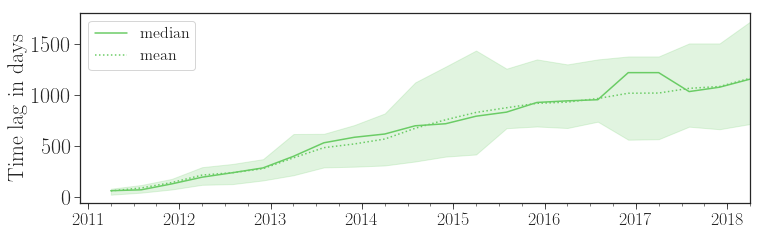

In [42]:

size=[12,20,70]
df_=(df_all_time.
     groupby(pd.Grouper(key='date', freq='4M'))['time_lag'].
     describe()[['mean', '25%', '50%', '75%']] 
    )

df_tmp=df_
df_tmp['50%'].rename('median').plot(color=green)
ax=df_tmp['mean'].plot(style=':',color=green)
ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], alpha=0.2, color=green)

ax.set(
    xlabel='',
    ylabel='Time lag in days',
    xlim=date_period,
    #ylim=(0,size),
)
ax.legend(loc='upper left',  prop={'size': 16, 'weight':'bold'})
ax.figure.set_size_inches(12,3.5)
#plt.ticklabel_format(axis='y',style='sci',scilimits=(0,3))
ax.figure.savefig('/home/neglectos/Desktop/repositories/jsep18technicallag/figures/transitive_tl.eps', bbox_inches='tight', facecolor='white')

In [72]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_tmp.reset_index().reset_index().index,
                       df_tmp.reset_index().reset_index()['50%'])
print ("r-squared:", r_value**2)

r-squared: 0.958640552901


# Evoluton on levels

In [59]:
#version_lag_show(df_all_sum.query('level=="0"'), [10,20,50])

In [19]:
# Number of dependencies per level
df_all['level']=df_all['level'].apply(int)
df_tmp=df_all.groupby(['level']).count()[['dependency']]*100/len(df_all)
df_tmp['dependency2']=df_tmp.dependency.cumsum()

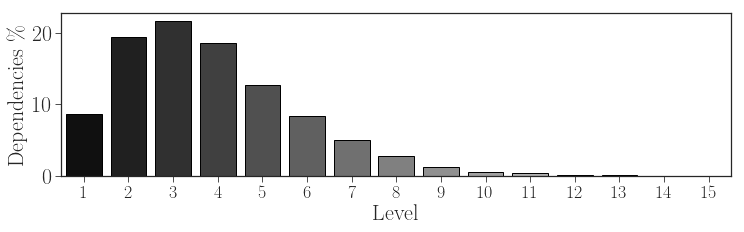

In [97]:
# Number of dependencies per level
#df_tmp=df_all.groupby(['level']).count()[['dependency']]*100/len(df_all)
#df_tmp['dependency']=df_tmp.dependency.cumsum()

#df_tmp.reset_index(inplace=True)
#df_tmp['level']=df_tmp['level']+1

ax = sns.barplot( x='level', y="dependency", palette='gray', data=df_tmp.query('level<16'))
ax.figure.set_size_inches(12,3)
ax.set_xlabel('Level')
ax.set_ylabel('Dependencies \%')
for patch in ax.patches:
    patch.set_edgecolor('black')
#ax.set_ylim(90,100)
ax.legend( loc='upper right', bbox_to_anchor=(1, 1), fontsize=20)#,ncol=3)#, fancybox=True, shadow=True)

# Time lag evolution per level

In [13]:
df_all_time_level=(df_all
  .drop(['Major','Minor','Patch'],axis=1)
 .groupby(['package','date','level'])
 .agg('max')
 .reset_index()
)
df_all_time_level['date']=df_all_time_level['date'].apply(lambda x : str(x).split('-')[0]+'-'+str(x).split('-')[1])

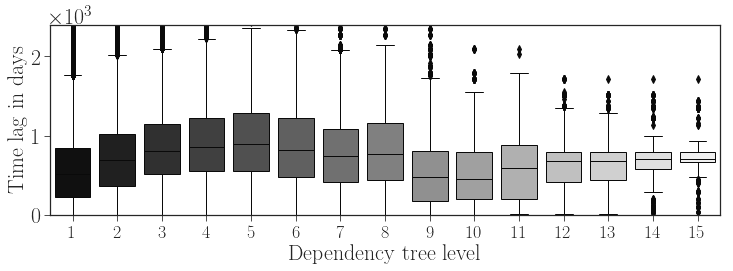

In [21]:
# Version lag evolution considering all dependencies
order=['2015-04',
 '2015-08',
 '2015-12',
 '2016-04',
 '2016-08',
 '2016-12',
 '2017-04',
 '2017-08',
 '2017-12',
 '2018-04']
ax = sns.boxplot(x="level", 
                 y="time_lag", 
                 data=df_all_time_level.query('level<16'),
                 palette="gray", linewidth=1)
ax.figure.set_size_inches(12,3.5)
ax.set_xlabel("Dependency tree level")
ax.set_ylabel('Time lag in days')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.set_ylim(0,2400)
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,3))
ax.legend(loc='upper right',  bbox_to_anchor=(0.8, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
#ax.figure.savefig('/home/neglectos/Desktop/jsep18technicallag/figures/transitive_evolution_time_level.png', bbox_inches='tight', facecolor='white')

# Time lag wrt to depth

In [43]:
tmp_df=df_all.head(62889161)[['package','date','level']].groupby(['package','date']).max().reset_index()
tmp_df['date']=tmp_df['date'].apply(lambda x : str(x).split('-')[0]+'-'+str(x).split('-')[1])
tmp_df['date']=pd.to_datetime(tmp_df['date'])

In [44]:
time_lag_depth=(df_all_time[['package','date','time_lag']].set_index(['package','date']).
                merge(tmp_df.set_index(['package','date']),
                      left_index=True,
                      right_index=True,
                      how='left'
                     )
                .reset_index()
                #.dropna()
               )
len(time_lag_depth)

2104051

In [45]:
time_lag_depth['level'] = time_lag_depth['level'].astype(int)

In [73]:
time_lag_depth.date.drop_duplicates()

0       2016-12-01
1       2017-04-01
2       2017-08-01
3       2017-12-01
4       2018-03-01
7       2015-12-01
8       2016-04-01
9       2016-08-01
73      2015-08-01
102     2014-08-01
103     2014-12-01
104     2015-04-01
384     2013-12-01
385     2014-04-01
402     2013-04-01
403     2013-08-01
418     2012-12-01
3371    2011-08-01
3383    2011-12-01
3384    2012-04-01
3385    2012-08-01
81290   2011-04-01
Name: date, dtype: datetime64[ns]

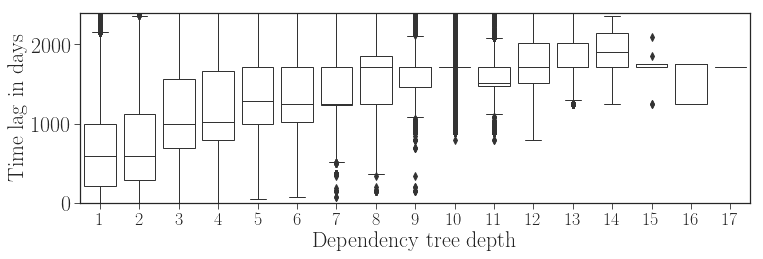

In [95]:

ax = sns.boxplot(x="level", 
                 y="time_lag", 
                 data=time_lag_depth.query('date == "2018-03-01"').query('level<18'),
                 color="white", linewidth=1, saturation=0.5)
plt.setp(ax.lines, color=".2", mfc='.2', mec='.2')
for x in ax.artists:
    x.set_edgecolor('.2')
ax.figure.set_size_inches(12,3.5)
ax.set_xlabel("Dependency tree depth")
ax.set_ylabel('Time lag in days')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.set_ylim(0,2400)
#plt.ticklabel_format(axis='y',style='sci',scilimits=(0,3))
ax.legend(loc='upper right',  bbox_to_anchor=(0.8, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.figure.savefig('/home/neglectos/Desktop/repositories/jsep18technicallag/figures/dependency_tree_depth.eps', bbox_inches='tight', facecolor='white')

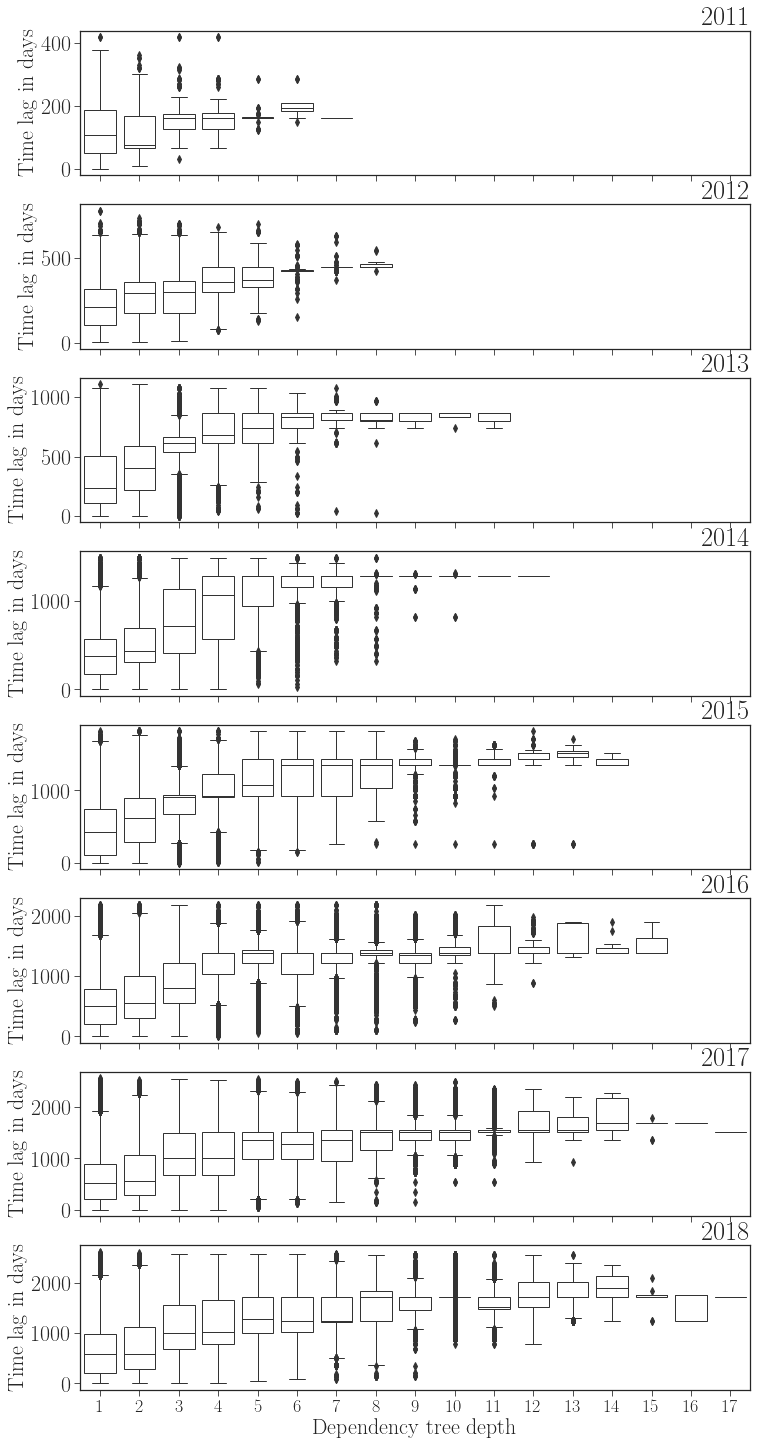

In [83]:
fig, axes = plt.subplots(8, 1, sharex=True, sharey=False)
for i, year in enumerate(range(2011,2019)):
    date = str(year)+'-12-01'
    if year == 2018:
        date = '2018-03-01'
    
    time_lag_depth_year = time_lag_depth.query('date =="'+date+'"')

    
    ax = sns.boxplot(x="level", 
                     y="time_lag", 
                     ax = axes[i],
                     data=time_lag_depth_year.query('level<18'),
                     color="white", linewidth=1, saturation=0.5)
    plt.setp(ax.lines, color=".2", mfc='.2', mec='.2')
    for x in ax.artists:
        x.set_edgecolor('.2')
    ax.figure.set_size_inches(12,25)
    ax.set_title(str(year), loc='right')
    #ax.set_xlabel("Dependency tree depth")
    ax.set_xlabel("")
    ax.set_ylabel('Time lag in days')
    for patch in ax.patches:
        patch.set_edgecolor('black')
    #ax.set_ylim(0,2400)
    #plt.ticklabel_format(axis='y',style='sci',scilimits=(0,3))
    ax.legend(loc='upper right',  bbox_to_anchor=(0.8, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.set_xlabel("Dependency tree depth")
#ax.figure.savefig('/home/neglectos/Desktop/repositories/jsep18technicallag/figures/dependency_tree_depth.png', bbox_inches='tight', facecolor='white')

# Correlating the number of deps to the depth

In [96]:
df_all['level']=df_all['level'].apply(int)

In [102]:
maximum = df_all.date.max()
df_all_deps = df_all.query('date == "'+maximum+'"')

In [103]:
df_all_deps=(df_all_deps.groupby(['package','date']).count()[['dependency']]
             .merge(df_all_deps[['package','date','level']].groupby(['package','date']).max(),
                    left_index=True,
                    right_index=True,
                    how='left'
                   )
             .dropna()
             .reset_index()
            )
len(df_all_deps)

319290

In [104]:
df_all_deps=df_all_deps[['package','dependency','level']].drop_duplicates()

In [ ]:
time_lag_depth.query('date == "2018-03-01"')

In [107]:
scipy.stats.pearsonr(df_all_deps.dependency,
                     df_all_deps.level)

(0.70484606059695654, 0.0)

# analyzing which constraints are used by those who have low number of deps

In [55]:
technical_lag=pd.read_csv('../../../jsep2018/csv/packages/technical_lag_clean.csv', usecols=['package','version','kind','constraint_type'],
                          sep=';', dtype=object, index_col=None,  error_bad_lines=False)
print(len(technical_lag))
technical_lag.head(2)

51029864


,package,version,kind,constraint_type
0,shaybagants-test,1.0.0,runtime,latest
1,shaybagants-test,2.0.0,runtime,latest


In [51]:
technical_lag.kind.drop_duplicates()

0              runtime
10         Development
1401715       Optional
Name: kind, dtype: object

In [56]:
technical_lag=technical_lag.query('kind=="runtime"')

In [57]:
technical_lag.drop(['kind'], axis=1, inplace=True)

In [58]:
exclude_prefixes = ('@ryancavanaugh/pkg', 'all-packages-', 'cool-', 'neat-', 'wowdude-', 'npmdoc-', 'npmtest-', 'npm-ghost-',)
exclude_suffixes = ('-cdn',)
exclude_ghost = r'^ghost-\d+$'

In [59]:
technical_lag=technical_lag[~technical_lag['package'].str.startswith(exclude_prefixes)]
technical_lag=technical_lag[~technical_lag['package'].str.endswith(exclude_suffixes)]
technical_lag=technical_lag[~technical_lag['package'].str.match(exclude_ghost)]

In [76]:
technical_lag['package']=technical_lag['package']+"@"+technical_lag['version']

In [79]:
deps=technical_lag.groupby('package').count()[['version']].reset_index()

In [80]:
deps_const=technical_lag.groupby(['package','constraint_type']).count().reset_index()

In [81]:
deps_const['deps_const']=deps_const['version']
deps['deps']=deps['version']

In [82]:
deps.drop('version', axis=1, inplace=True)
deps_const.drop('version', axis=1, inplace=True)

In [97]:
new_df=(deps
        .merge(deps_const,
               left_on='package',
               right_on='package',
               how='left'
              )
        .dropna()
       )

In [15]:
new_df=new_df.query('deps<=30')

In [98]:
mask= new_df.package.isin(df_all.package)
new_df=new_df[mask]

In [93]:
new_df['propotion']=new_df['deps_const']/new_df['deps']

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [99]:
new_df.to_csv('/home/neglectos/Desktop/new_df.csv', index=False, sep=';')

In [12]:
new_df=pd.read_csv('/home/neglectos/Desktop/new_df.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)


In [13]:
new_df['deps']=new_df['deps'].apply(int)
new_df['deps_const']=new_df['deps_const'].apply(int)

In [14]:
new_df['propotion']=new_df['deps_const']/new_df['deps']

In [21]:
new_df=new_df.query('deps<=2')

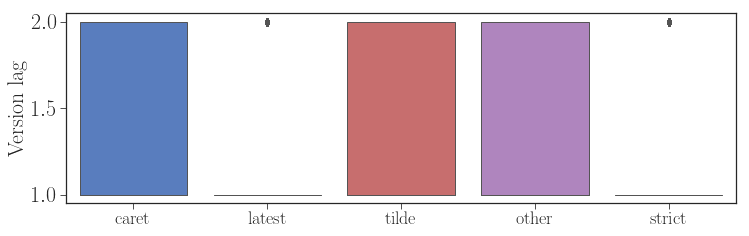

In [22]:
ax = sns.boxplot(x="constraint_type", 
                 y="deps_const", 
                 data=new_df,#.query('level=="0"'),
                 #hue='constraint_type',
                 palette="muted", linewidth=1)
ax.figure.set_size_inches(12,3.5)
ax.set_xlabel("")
ax.set_ylabel('Version lag')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right',  bbox_to_anchor=(0.8, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)

In [28]:
new_df.groupby('constraint_type').count()['package']/len(new_df)

constraint_type
caret     0.606155
latest    0.058067
other     0.092130
strict    0.119991
tilde     0.123658
Name: package, dtype: float64

In [5]:
versions=pd.read_csv('../../../jsep2018/csv/versions_npm_march.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)
#versions=versions[['package','version','release_type']]
versions.sort_values(['package','date','version'], ascending=True, inplace=True)
versions['date']=pd.to_datetime(versions['date'])
print(len(versions))
versions.head(2)

4760450


,package,version,date,semver,release_type,Major,Minor,Patch
0,0,0.0.0,2014-04-01,0.0.0,initial,0,0,0
1,0-,0.0.1,2017-03-06,0.0.1,initial,0,0,1


In [22]:
versions.package.drop_duplicates().size

698648

In [6]:
tmp=df_all[['level','package','dependency','date']].drop_duplicates()

In [8]:
tmp=tmp.groupby('level').count()*100/len(tmp)

In [10]:
tmp['package']=tmp['package'].cumsum()

In [195]:
versions=pd.read_csv('../../../jsep2018/csv/versions_npm_march.csv',
                          sep=';', dtype=object, index_col=None,  error_bad_lines=False)

In [197]:
aa = versions.groupby('package').count().reset_index().query('version==1')

In [199]:
mask  = versions.package.isin(aa.package)
versions = versions [mask]

In [201]:
versions['pre'] = versions['version'].apply(lambda x: "-" in str(x))

In [205]:
dependencies=pd.read_csv('../../../jsep2018/csv/packages/dependencies_npm_march.csv',
                          sep=';', dtype=object, index_col=None,  error_bad_lines=False)

In [206]:
dependencies['pre'] =  dependencies['constraint'].apply(lambda x: "-" in x)

In [207]:
dependencies.groupby('pre').count()

,package,version,dependency,kind,constraint,date,release_type
pre,,,,,,,
False,51649326,51649595,51631896,51649595,51649595,51649595,51649595
True,1190601,1190601,1190529,1190601,1190601,1190601,1190601


In [208]:
len(dependencies)

52840196